# imports

In [70]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
from nltk.tokenize import RegexpTokenizer, TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score

In [ ]:

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, silhouette_score

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

# data cleaning

In [ ]:
# import data
df = pd.read_csv("../data/brands_and_product_tweets.csv")
df.head()

In [ ]:
# rename columns for readability
df = df.rename(columns = {'tweet_text': 'tweet',
                          'emotion_in_tweet_is_directed_at': 'product',
                          'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'})
df.info()

In [ ]:
# explore null values
df.isna().sum()

In [ ]:
# view rows where 'tweet' is null
df[df['tweet'].isna()]

In [ ]:
# drop null rows
df.dropna(subset=['tweet'], inplace=True)

In [ ]:
# view distribution of sentiment labels
df['sentiment'].value_counts()

In [ ]:
# rename sentiment labels
df['sentiment'] = df['sentiment'].replace({"No emotion toward brand or product": "neutral",
                                           "Positive emotion": "positive",
                                           "Negative emotion": "negative",
                                           "I can't tell": "unclear"})
df['sentiment'].value_counts()

In [ ]:
# view distribution of product labels
df['product'].value_counts()

In [ ]:
# view rows where 'product' is null
df[df['product'].isna()]

In [ ]:
# fill null rows with 'unassigned'
df['product'].fillna('unassigned', inplace = True)

In [20]:
# categorize products by brand

# create column 'brand' with default value 'NA'
df['brand'] = 'NA'

# define conditions using 'product' name
product_apple = df['product'].str.contains('apple|ip', case=False)
product_google = df['product'].str.contains('google|android', case=False)

# fill in 'brand' using defined conditions
df.loc[product_apple, 'brand'] = 'apple'
df.loc[product_google, 'brand'] = 'google'

# view distribution of of brand labels
df.groupby(['brand', 'product']).size()

brand   product                        
NA      unassigned                         5551
apple   Apple                               640
        Other Apple product or service       34
        iPad                                910
        iPad or iPhone App                  451
        iPhone                              288
google  Android                              74
        Android App                          78
        Google                              412
        Other Google product or service     282
dtype: int64

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8720 entries, 0 to 8720
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      8720 non-null   object
 1   product    8720 non-null   object
 2   sentiment  8720 non-null   object
 3   brand      8720 non-null   object
dtypes: object(4)
memory usage: 340.6+ KB


In [ ]:
### WIP ###

# define function to identify brand mentioned in tweet text

def tweet_brand(row):
    tweet_apple = row['tweet'].str.contains('apple|iphone|ipad', case=False)
    tweet_google = row['tweet'].str.contains('google|android', case=False)

    if row['brand'] == 'NA':    
        if tweet_apple and tweet_google:
            return 'both'
        elif tweet_apple:
            return 'apple'
        elif tweet_google:
            return 'google'
    return row['brand']

# apply the function to each row and return results to 'brand'
df['brand'] = df.apply(tweet_brand, axis=1)


#df['brand'].value_counts()
#df.groupby(['brand', 'product']).size()

In [21]:
# check for duplicate rows
df[df.duplicated()]

,tweet,product,sentiment,brand
457,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,positive,apple
752,Google to Launch Major New Social Network Call...,unassigned,neutral,NA
2138,Marissa Mayer: Google Will Connect the Digital...,unassigned,neutral,NA
2437,Counting down the days to #sxsw plus strong Ca...,Apple,positive,apple
3759,Really enjoying the changes in Gowalla 3.0 for...,Android App,positive,google
3771,"#SXSW is just starting, #CTIA is around the co...",Android,positive,google
4669,"Oh. My. God. The #SXSW app for iPad is pure, u...",iPad or iPhone App,positive,apple
5107,RT @mention ��� GO BEYOND BORDERS! ��_ {link} ...,unassigned,neutral,NA
5110,"RT @mention ��� Happy Woman's Day! Make love, ...",unassigned,neutral,NA
5650,RT @mention Google to Launch Major New Social ...,unassigned,neutral,NA


In [22]:
# drop duplicates
df.drop_duplicates(inplace=True)

In [23]:
# reset index after dropping rows
df.reset_index(drop=True, inplace=True)
df

,tweet,product,sentiment,brand
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,negative,apple
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,positive,apple
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,positive,apple
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,negative,apple
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,positive,google
...,...,...,...,...
8693,Ipad everywhere. #SXSW {link},iPad,positive,apple
8694,"Wave, buzz... RT @mention We interrupt your re...",unassigned,neutral,NA
8695,"Google's Zeiger, a physician never reported po...",unassigned,neutral,NA
8696,Some Verizon iPhone customers complained their...,unassigned,neutral,NA


# data viz

In [41]:
def tweet_countplot(df, col, hue=None):
    sns.countplot(data=df, x=col, hue=hue)
    plt.xticks(rotation=90)
    plt.title(f'distribution of tweets by {col}')
    plt.show()


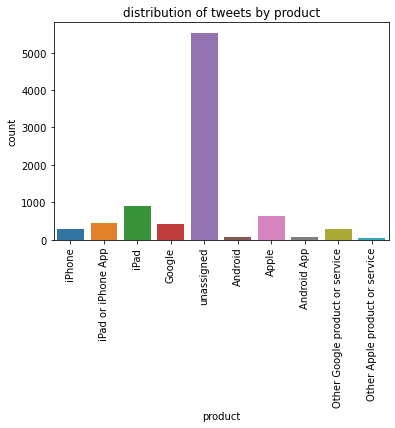

In [72]:
tweet_countplot(df, 'product')

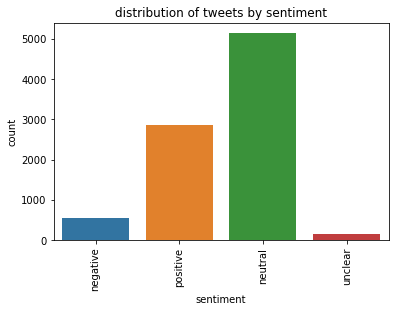

In [37]:
tweet_countplot(df, 'sentiment')

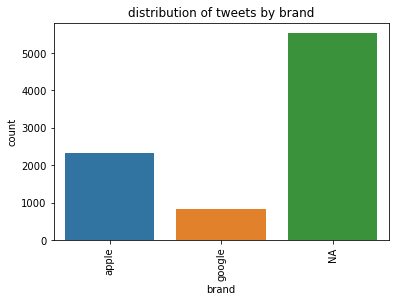

In [39]:
tweet_countplot(df, 'brand')

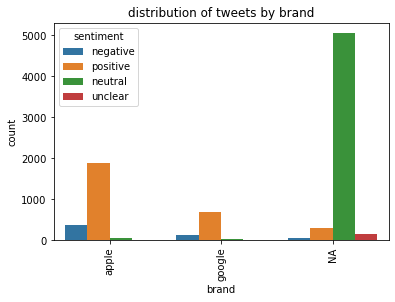

In [42]:
tweet_countplot(df, 'brand', hue='sentiment')

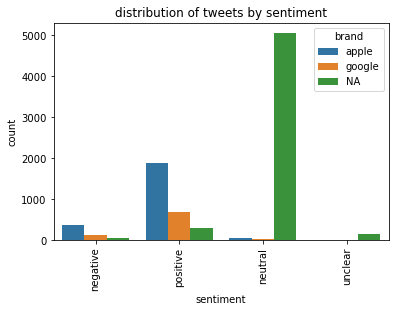

In [43]:
tweet_countplot(df, 'sentiment', hue='brand')

# preprocessing

In [46]:
# define stopwords
stopwords = stopwords.words('english')

words_to_add = ['sxsw','link', 'rt']

stopwords.extend(words_to_add)

In [47]:
# set up tokenizer
tokenizer = RegexpTokenizer(r"(?u)\w{3,}")
tweet_tknzr = TweetTokenizer(strip_handles=True)

lemmer = WordNetLemmatizer()
#p_stemmer = PorterStemmer()
#s_stemmer = SnowballStemmer()

In [49]:
def clean_tweet(text):
    # remove twitter handles
    tokens = tweet_tknzr.tokenize(text)
    text = " ".join(tokens)
    
    # remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # remove @ and #
    text = re.sub(r'\@\w+|\#','', text)
    
    # remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # remove special characters and numbers
    text = re.sub(r"[^a-zA-Z']", ' ', text)
    
    # convert to lowercase
    text = text.lower()

    # remove words under 3 letters
    tokens = tokenizer.tokenize(text)

    # remove stopwords
    tokens = [token for token in tokens if token not in stopwords]
    
    # lemmatize tokens
    tokens = [lemmer.lemmatize(token) for token in tokens]

    #Turn the lemma list into a string for the Vectorizer
    text = " ".join(tokens) 
    return text

In [54]:
df['clean_tweet'] = df['tweet'].apply(clean_tweet)
df

,tweet,product,sentiment,brand,clean_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,negative,apple,iphone hr tweeting rise austin dead need upgra...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,positive,apple,know awesome ipad iphone app likely appreciate...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,positive,apple,wait ipad also sale
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,negative,apple,hope year festival crashy year iphone app
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,positive,google,great stuff fri marissa mayer google tim reill...
...,...,...,...,...,...
8693,Ipad everywhere. #SXSW {link},iPad,positive,apple,ipad everywhere
8694,"Wave, buzz... RT @mention We interrupt your re...",unassigned,neutral,NA,wave buzz interrupt regularly scheduled geek p...
8695,"Google's Zeiger, a physician never reported po...",unassigned,neutral,NA,google zeiger physician never reported potenti...
8696,Some Verizon iPhone customers complained their...,unassigned,neutral,NA,verizon iphone customer complained time fell b...


In [ ]:
# jacob clean_text function

def clean_text(text):
    # Check if the text is a string
    if not isinstance(text, str):
        return ''  # Return empty string if text is not a string
    # Remove URLs items
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    text = re.sub(r'\@\w+|\#','', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and numbers
    text = re.sub(r"[^a-zA-Z']", ' ', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    stop_words = set(stopwords.words('english')) | {'sxsw','link','rt'}
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    return text

# Clean the tweet_text column
df['cleaned_tweet_text'] = df['tweet_text'].apply(clean_text)

In [ ]:
# jacob lemmatizer function

# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to lemmatize text
def lemmatize_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Lemmatize each word
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Rejoin lemmatized tokens into a string
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text

# Example text
example_text = "Fall Out Boy Rules."

# Lemmatize the example text
lemmatized_text = lemmatize_text(example_text)
print(lemmatized_text)

# modeling

In [62]:
# rename sentiment labels
df['sentiment'] = df['sentiment'].replace({"neutral": 0,
                                           "positive": 1,
                                           "negative": 0,
                                           "unclear": 0})
df['sentiment'].value_counts()

0    5837
1    2861
Name: sentiment, dtype: int64

In [63]:
# train test split
X = df[['clean_tweet']]
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [65]:
# baseline prediction
y_train.value_counts(normalize=True)

0    0.672895
1    0.327105
Name: sentiment, dtype: float64

In [71]:
# untuned tf-idf and simple nb

pipe_nb = Pipeline(steps=[
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

cross_validate(pipe_nb, X_train, y_train, scoring='accuracy', return_train_score=True)


/Users/meghanapakala/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/meghanapakala/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/meghanapakala/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/meghanapakala/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/naive_bayes.py", line 615, in fit
    X, y = self._check_X_y(X, y)
  File "/Users/meghanapakala/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/naive_bayes.py", line 480, in _check_X_y
    return self._validate_data(X, y, accept_sp

{'fit_time': array([0.00178313, 0.00134087, 0.00125909, 0.0012238 , 0.00138974]),
 'score_time': array([0., 0., 0., 0., 0.]),
 'test_score': array([nan, nan, nan, nan, nan]),
 'train_score': array([nan, nan, nan, nan, nan])}